# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import variable
from torchvision import datasets,transforms,models
from torchvision import models
# import helper
import torchvision
from torchvision import transforms,datasets
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
import glob, os

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(255),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                       ])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                        transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# TODO: Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir,transform=train_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_dl  =torch.utils.data.DataLoader(train_datasets,batch_size=32,shuffle=True) 

# TODO: Load the datasets with ImageFolder
valid_datasets = datasets.ImageFolder(valid_dir,transform=train_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
valid_dl  =torch.utils.data.DataLoader(valid_datasets,batch_size=32,shuffle=True)

# TODO: Load the datasets with ImageFolder
test_datasets = datasets.ImageFolder(test_dir,transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
test_dl  =torch.utils.data.DataLoader(test_datasets,batch_size=32,shuffle=True)


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [7]:
!pip install --upgrade torch torchvision

        83% |██████████████████████�███▉     | 738.3MB 29.0MB/s eta 0:00:05��              | 490.1MB 46.5MB/s eta 0:00:0955% |█████████████████▉              | 492.1MB 17.3MB/s eta 0:00:23�██████████████              | 493.6MB 67.6MB/s eta 0:00:06█████████              | 495.1MB 58.7MB/s eta 0:00:07��███              | 496.5MB 20.6MB/s eta 0:00:19   | 498.6MB 26.9MB/s eta 0:00:15��██████████▏             | 500.0MB 61.1MB/s eta 0:00:07    | 502.2MB 62.5MB/s eta 0:00:07    57% |██████████████████▎             | 504.2MB 45.9MB/s eta 0:00:090.8MB/s eta 0:00:07��█████████████████▍             | 507.3MB 31.1MB/s eta 0:00:13██████▌             | 509.3MB 16.0MB/s eta 0:00:24K    57% |██████████████████▌             | 510.8MB 59.6MB/s eta 0:00:07             | 512.2MB 23.3MB/s eta 0:00:16�██████████████▋             | 513.7MB 59.2MB/s eta 0:00:07|██████████████████▊             | 515.0MB 15.1MB/s eta 0:00:25�██████████▊             | 516.0MB 29.1MB/s eta 0:00:13517.1MB 12.4MB/s eta 0:00:30��███

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [5]:
# # TODO: Build and train your network
model= torchvision.models.alexnet(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:02<00:00, 85216464.61it/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [6]:
for param in model.parameters():
    param.requires_grad=False

In [11]:
# # Training model
def train_model(model,train_dl,valid_dl,epochs,print_every,criterian,opt,device="cpu"):
    steps=0
    model.to(device)
    for e in range(epochs):
        running_loss=0
        for ii,(images,labels) in enumerate(train_dl):
            
            steps += 1

            images, labels = images.to(device), labels.to(device)

            opt.zero_grad()

            # Forward and backward passes
            outputs = model.forward(images)
            loss =criterian(outputs, labels)
            loss.backward()
            opt.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                valid_accuracy = validation(valid_dl,device)
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every),
                      "Validation Accuracy: {}".format(round(valid_accuracy,4)))

                running_loss = 0
# def loss_batch(model,loss_func,xb,yb,opt=None,metric=None):
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     xb,yb = xb.to(device), yb.to(device)
#     preds=model(xb)
#     loss=loss_func(preds,yb)
# #     if opt is not None:
#         loss.backward()
#         opt.step()
#         opt.zero_grad()
#     metric_result=None
#     if metric is not None:
#         metric_result=metric(preds,yb)
#     return loss.item(),len(xb),metric_result



In [8]:
# def accuracy(output,labels):
#     _,preds=torch.max(output,dim=1)
# #     return torch.sum(preds==labels).item()/len(preds)
def validation(valid_dl,device="cpu"):
    correct=total=0
    with torch.no_grad():
        for images,labels in valid_dl:
            images,labels=images.to(device),labels.to(device)
            output=model(images)
            _,pred=torch.max(output.data,1)
            total+=labels.size(0)
            correct+=(pred==labels).sum().item()
    return (correct/total)*100        

In [14]:
# def evaluate(model,loss_fn,valid_dl,metric=accuracy):
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     with torch.no_grad():
# #         results=[loss_batch(model,loss_fn,xb,yb,metric=metric) for xb,yb in valid_dl]
#         losses,nums,metrics=zip(*results)
#         total=np.sum(nums).item()
#         avg_loss=np.sum(np.multiply(losses,nums))/total
#         avg_metric=None
#         if metric:
#             avg_metric=np.sum(np.multiply(metrics,nums))/total
#         return avg_loss,total,avg_metric    

In [15]:
# def fit(epochs,model,loss_fn,train_dl,valid_dl,opt_fn=None,lr=0.01,metric=accuracy):
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     train_losses,val_losses,val_metrics=[],[],[]
#     if opt_fn is None:
#         opt_fn=torch.optim.SGD
#     opt=opt_fn(model.classifier.parameters(),lr=lr)
#     for epoch in range(epochs):
#         model.train()
#         for xb,yb in train_dl:
#             xb,yb = xb.to(device), yb.to(device)
#             train_loss,_,_=loss_batch(model,loss_fn,xb,yb,opt)
#         model.eval()
#         result=evaluate(model,loss_fn,valid_dl,metric)
#         val_loss,total,val_metric=result
#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         val_metrics.append(val_metric)
#         if metric is None:
#             print("Epoch [{}/{}] , train_loss: {:4f} ,val_loss: {:4f}".format(epoch+1,epochs,train_loss,val_loss))
#         else:
#               print("Epoch [{}/{}] , train_loss: {:4f} ,val_loss: {:4f} ,val_{}: {:.4f}".format(epoch+1,epochs,train_loss,val_loss,metric.__name__,val_metric))
#         return train_losses,val_losses,val_metrics        

In [16]:
# def to_device(data,device):
#     if isinstance(data,(list,tuple)):
#         return [to_device(x,device) for x in data]
#     return data.to(device,non_blocking=True)

In [9]:
# from torchvision.models import vgg16,resnet18,googlenet,efficientnet_b0
# models=[models.efficientnet_b0(),models.vgg16(),models.resnet18,models.googlenet()]
from collections import OrderedDict
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


classifier=nn.Sequential(OrderedDict([
("fc1",nn.Linear(9216,4096))
,("relu1",nn.ReLU()),
("d1",nn.Dropout(0.2)),
    ("fc2",nn.Linear(4096,1024))
,("relu2",nn.ReLU()),
("d2",nn.Dropout(0.2)),
("fc3",nn.Linear(1024,102)),
('output', nn.LogSoftmax(dim=1))
]))


model.classifier=classifier
model.to(device)


  

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu1): ReLU()
    (d1): Dropout(p=0.2)
    (fc2): Linear(in_features=4096, out_features=1024, bias=True)
   

In [12]:
from torch import optim
opt=optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
train_model(model,train_dl,valid_dl,5,50,nn.NLLLoss(),opt,device)

Epoch: 1/5...  Loss: 4.5090 Validation Accuracy: 6.9682
Epoch: 1/5...  Loss: 4.1464 Validation Accuracy: 14.4254
Epoch: 1/5...  Loss: 3.7515 Validation Accuracy: 25.9169
Epoch: 1/5...  Loss: 3.2550 Validation Accuracy: 30.9291
Epoch: 2/5...  Loss: 2.5350 Validation Accuracy: 35.6968
Epoch: 2/5...  Loss: 2.5170 Validation Accuracy: 44.4988
Epoch: 2/5...  Loss: 2.2757 Validation Accuracy: 47.6773
Epoch: 2/5...  Loss: 2.0489 Validation Accuracy: 48.1663
Epoch: 3/5...  Loss: 1.4503 Validation Accuracy: 52.5672
Epoch: 3/5...  Loss: 1.8020 Validation Accuracy: 56.357
Epoch: 3/5...  Loss: 1.6338 Validation Accuracy: 57.0905
Epoch: 3/5...  Loss: 1.5409 Validation Accuracy: 59.4132
Epoch: 4/5...  Loss: 1.0319 Validation Accuracy: 61.9804
Epoch: 4/5...  Loss: 1.3856 Validation Accuracy: 61.1247
Epoch: 4/5...  Loss: 1.3534 Validation Accuracy: 63.0807
Epoch: 4/5...  Loss: 1.3132 Validation Accuracy: 64.0587
Epoch: 5/5...  Loss: 0.7414 Validation Accuracy: 63.6919
Epoch: 5/5...  Loss: 1.1557 Valid

In [13]:
opt=optim.SGD(model.classifier.parameters(), lr=0.0001, momentum=0.9)
train_model(model,train_dl,valid_dl,3,30,nn.NLLLoss(),opt,device)

Epoch: 1/3...  Loss: 1.0472 Validation Accuracy: 70.9046
Epoch: 1/3...  Loss: 0.9768 Validation Accuracy: 71.8826
Epoch: 1/3...  Loss: 1.0105 Validation Accuracy: 71.6381
Epoch: 1/3...  Loss: 0.9676 Validation Accuracy: 74.2054
Epoch: 1/3...  Loss: 1.0047 Validation Accuracy: 73.5941
Epoch: 1/3...  Loss: 0.9132 Validation Accuracy: 71.0269
Epoch: 2/3...  Loss: 0.1705 Validation Accuracy: 72.4939
Epoch: 2/3...  Loss: 1.0239 Validation Accuracy: 72.4939
Epoch: 2/3...  Loss: 0.9108 Validation Accuracy: 73.2274
Epoch: 2/3...  Loss: 0.9833 Validation Accuracy: 72.6161
Epoch: 2/3...  Loss: 0.9083 Validation Accuracy: 72.7384
Epoch: 2/3...  Loss: 0.9289 Validation Accuracy: 71.1491
Epoch: 2/3...  Loss: 0.9675 Validation Accuracy: 71.0269
Epoch: 3/3...  Loss: 0.3042 Validation Accuracy: 74.0831
Epoch: 3/3...  Loss: 0.9526 Validation Accuracy: 73.1051
Epoch: 3/3...  Loss: 0.9440 Validation Accuracy: 72.8606
Epoch: 3/3...  Loss: 0.9169 Validation Accuracy: 72.8606
Epoch: 3/3...  Loss: 1.0263 Val

In [27]:
# epochs = 10
# steps = 0
# running_loss = 0
# print_every = 5
# optimizer=torch.optim.Adam(model.classifier.parameters(),lr=0.001)
# criterion=F.cross_entropy
# for epoch in range(epochs):
#     for inputs, labels in train_dl:
#         steps += 1
#         # Move input and label tensors to the default device
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         optimizer.zero_grad()
        
#         logps = model.forward(inputs)
#         loss = criterion(logps, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
        
#         if steps % print_every == 0:
#             test_loss = 0
#             accuracy = 0
#             model.eval()
#             with torch.no_grad():
#                 for inputs, labels in valid_dl:
#                     inputs, labels = inputs.to(device), labels.to(device)
#                     logps = model.forward(inputs)
#                     batch_loss = criterion(logps, labels)
                    
#                     test_loss += batch_loss.item()
                    
#                     # Calculate accuracy
#                     ps = torch.exp(logps)
#                     top_p, top_class = ps.topk(1, dim=1)
#                     equals = top_class == labels.view(*top_class.shape)
#                     accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
#             print(f"Epoch {epoch+1}/{epochs}.. "
#                   f"Train loss: {running_loss/print_every:.3f}.. "
#                   f"valid loss: {test_loss/len(valid_dl):.3f}.. "
#                   f"valid accuracy: {accuracy/len(valid_dl):.3f}")
#             running_loss = 0
#             model.train()

Epoch 1/10.. Train loss: 2.603.. valid loss: 2.899.. valid accuracy: 0.329
Epoch 1/10.. Train loss: 3.265.. valid loss: 2.884.. valid accuracy: 0.333
Epoch 1/10.. Train loss: 3.355.. valid loss: 2.819.. valid accuracy: 0.340
Epoch 1/10.. Train loss: 2.988.. valid loss: 2.921.. valid accuracy: 0.329
Epoch 1/10.. Train loss: 2.582.. valid loss: 2.814.. valid accuracy: 0.339
Epoch 1/10.. Train loss: 3.342.. valid loss: 2.896.. valid accuracy: 0.350
Epoch 1/10.. Train loss: 3.007.. valid loss: 2.695.. valid accuracy: 0.360
Epoch 1/10.. Train loss: 3.080.. valid loss: 2.738.. valid accuracy: 0.368
Epoch 1/10.. Train loss: 2.983.. valid loss: 2.654.. valid accuracy: 0.388
Epoch 1/10.. Train loss: 3.067.. valid loss: 2.631.. valid accuracy: 0.394
Epoch 1/10.. Train loss: 3.026.. valid loss: 2.470.. valid accuracy: 0.402
Epoch 1/10.. Train loss: 2.850.. valid loss: 2.552.. valid accuracy: 0.413
Epoch 1/10.. Train loss: 2.853.. valid loss: 2.595.. valid accuracy: 0.399
Epoch 1/10.. Train loss: 

KeyboardInterrupt: 

In [ ]:
def plot_metric(metric_value):
    plt.plot(metric_value,"-x")
    plt.Xlabel("epoch")
    plt.Ylabel("accuracy")
    plt.title("accuracy vs no. of epochs")
plot_metrics([val_acc]+val_metrics)


In [ ]:
def plot_losses(train_losses,val_losses):
    plt.plot(train_losses,"-x")
    plt.plot(val_losses,"_o")
    plt.plot("epoch")
    plt.Ylabel("loss")
    plt.legend(["Loss vs No. of epochs"])
plot_losses([None]+train_losses,[val_losses]+val_losses)    

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device);
# from torch import optim
# criterion=nn.NLLLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# epochs=5
# steps = 0
# running_loss = 0
# print_every = 5
# for e in range(epochs):
   
   
#         for images, labels in dataloaders:
#             if device=="cuda":
#                 images.cuda()
#                 labels.cuda()
#             print(steps)
#             steps+=1
#             # Flatten MNIST images into a 784 long vector
#     #         images = images.view(images.shape[0], -1)

#             # TODO: Training pass
#             optimizer.zero_grad()
#             if device=="cuda":
#                 output=model.forward(images.to(device))
#             else:
#                 output=model.forward(images)

#             loss = criterion(output,labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#         else:
#             print(f"Training loss: {running_loss/len(trainloader)}")

# #             if steps % print_every == 0:
# #                 test_loss = 0
# #                 accuracy = 0
# #                 model.eval()
# #                 with torch.no_grad():
# #                     for inputs, labels in testloader:
# #                         inputs, labels = inputs.to(device), labels.to(device)
# #                         logps = model.forward(inputs)
# #                         batch_loss = criterion(logps, labels)

# #                     test_loss += batch_loss.item()
# #                                         # Calculate accuracy
# #                     ps = torch.exp(logps)
# #                     top_p, top_class = ps.topk(1, dim=1)
# #                     equals = top_class == labels.view(*top_class.shape)
# #                     accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

# #             print(f"Epoch {e+1}/{epochs}.. "
# #                   f"Train loss: {running_loss/print_every:.3f}.. "
# #                   f"Test loss: {test_loss/len(dataloaders):.3f}.. "
# #                   f"Test accuracy: {accuracy/len(dataloaders):.3f}")
# #             running_loss = 0
# #             model.train()

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [14]:
# TODO: Do validation on the test set
test_accuracy = validation(test_dl,device)
print("test Accuracy: {}".format(round(test_accuracy,4)))


test Accuracy: 83.3944


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [16]:
# TODO: Save the checkpoint 
model.class_to_idx=train_datasets.class_to_idx
checkpoint = {'transfer_model': 'alexnet',
              'input_size': 9216,
              'output_size': 102,
              'features': model.features,
              'classifier': model.classifier,
              'optimizer': opt.state_dict(),
              'state_dict': model.state_dict(),
              'idx_to_class': {v: k for k, v in train_datasets.class_to_idx.items()}
             }

torch.save(checkpoint,"checkpoint.pth")

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [18]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    model_info = torch.load(filepath)
    model = models.alexnet(pretrained=True)
    classifier=nn.Sequential(OrderedDict([
                        ("fc1",nn.Linear(9216,4096))
                        ,("relu1",nn.ReLU()),
                        ("d1",nn.Dropout(0.2)),
                            ("fc2",nn.Linear(4096,1024))
                        ,("relu2",nn.ReLU()),
                        ("d2",nn.Dropout(0.2)),
                        ("fc3",nn.Linear(1024,102)),
                        ('output', nn.LogSoftmax(dim=1))
                        ]))

    model.classifier = classifier
    model.load_state_dict(model_info['state_dict'])
    return model, model_info

model, model_info = load_checkpoint('checkpoint.pth')
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu1): ReLU()
    (d1): Dropout(p=0.2)
    (fc2): Linear(in_features=4096, out_features=1024, bias=True)
   

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [23]:
import numpy
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
#     image_resize=image.resize((256,256))
#     width=height=256
#     new_width=new_height=224
#     left = (width - new_width)/2
#     top = (height - new_height)/2
#     right = (width + new_width)/2
#     bottom = (height + new_height)/2
#     im1 = image_resize.crop((left, top, right, bottom))
#     np_image = np.array(im1)
    im = Image.open(image)
    width, height = im.size
    picture_coords = [width, height]
    max_span = max(picture_coords)
    max_element = picture_coords.index(max_span)
    if (max_element == 0):
        min_element = 1
    else:
        min_element = 0
    aspect_ratio=picture_coords[max_element]/picture_coords[min_element]
    new_picture_coords = [0,0]
    new_picture_coords[min_element] = 256
    new_picture_coords[max_element] = int(256 * aspect_ratio)
    im = im.resize(new_picture_coords)   
    width, height = new_picture_coords
    left = (width - 244)/2
    top = (height - 244)/2
    right = (width + 244)/2
    bottom = (height + 244)/2
    im = im.crop((left, top, right, bottom))
    np_image = np.array(im)
    np_image = np_image.astype('float64')
    np_image = np_image / [255,255,255]
    np_image = (np_image - [0.485, 0.456, 0.406])/ [0.229, 0.224, 0.225]
    np_image = np_image.transpose((2, 0, 1))
    return np_image
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [27]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

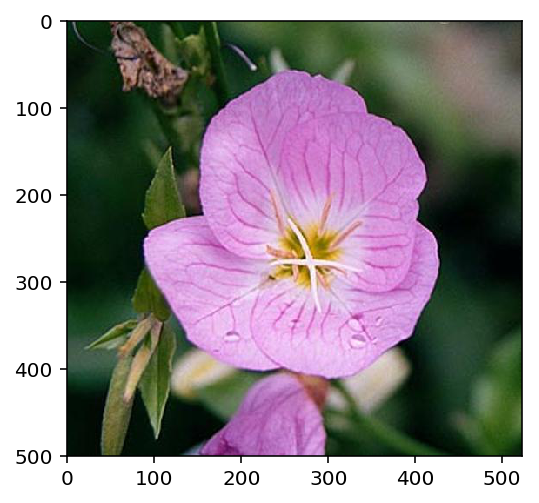

In [28]:
from os import listdir

im = Image.open('flowers/train/1/image_06734.jpg')
fig, ax = plt.subplots()
ax.imshow(im);

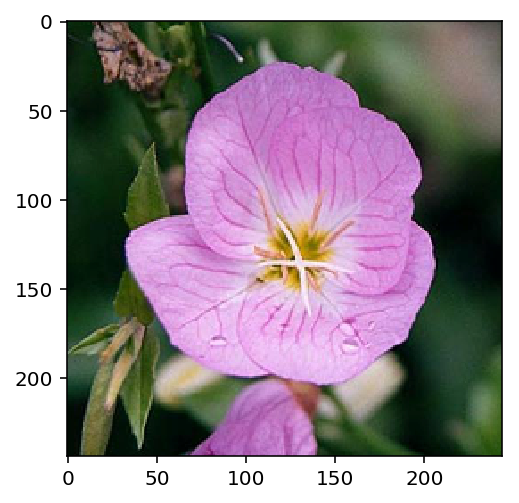

In [29]:
new_image = process_image('flowers/train/1/image_06734.jpg')
imshow(new_image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [32]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    with torch.no_grad():
        image=process_image(image_path)
        image=torch.from_numpy(image)
        image.unsqueeze_(0)
        image = image.float()
        model, _ = load_checkpoint(model)
        outputs = model(image)
        probs, classes = torch.exp(outputs).topk(topk)
        return probs[0].tolist(), classes[0].add(1).tolist()
    
predict('flowers/train/1/image_06734.jpg','checkpoint.pth')

([0.899407684803009,
  0.024119077250361443,
  0.02316451631486416,
  0.012607088312506676,
  0.012192320078611374],
 [1, 84, 31, 13, 79])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

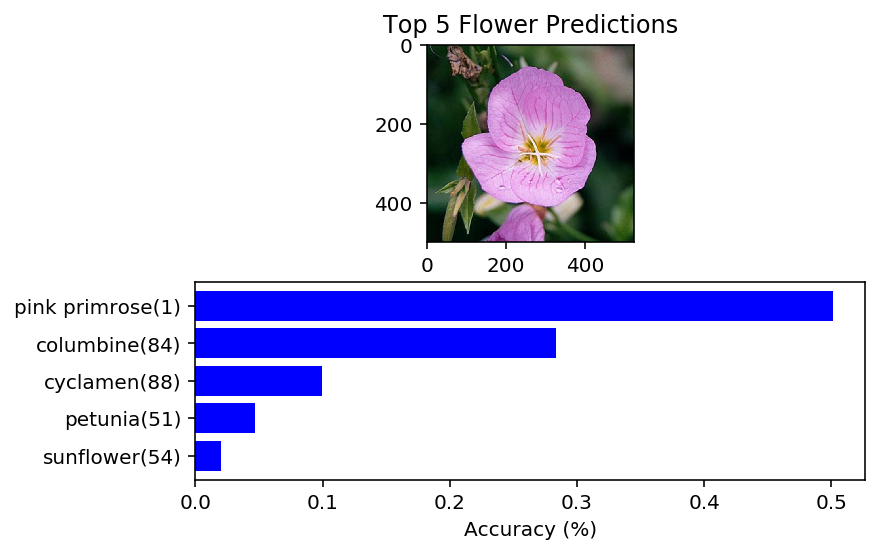

In [34]:
# TODO: Display an image along with the top 5 classes
def display_prediction(image_path,model):
    probs, classes = predict(image_path,'checkpoint.pth')
    plant_classes = [cat_to_name[str(cls)] + "({})".format(str(cls)) for cls in classes]
    im = Image.open(image_path)
    fig, ax = plt.subplots(2,1)
    ax[0].imshow(im);
    y_positions = np.arange(len(plant_classes))
    ax[1].barh(y_positions,probs,color='blue')
    ax[1].set_yticks(y_positions)
    ax[1].set_yticklabels(plant_classes)
    ax[1].invert_yaxis()  # labels read top-to-bottom
    ax[1].set_xlabel('Accuracy (%)')
    ax[0].set_title('Top 5 Flower Predictions')
    return None

display_prediction('flowers/train/1/image_06734.jpg','check.pth')

<font color='red'>**Reminder for Workspace users:** If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.</font>

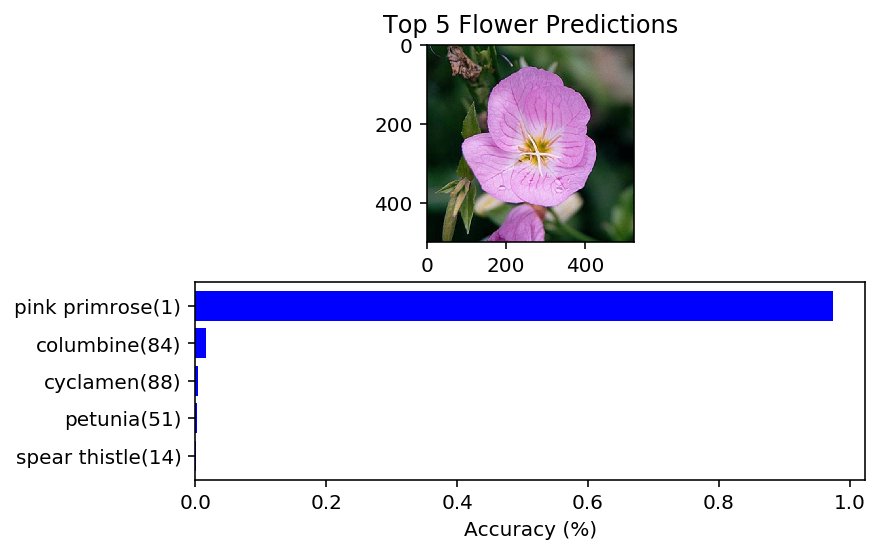

In [36]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace
def display_prediction(image_path,model):
    probs, classes = predict(image_path,'checkpoint.pth')
    plant_classes = [cat_to_name[str(cls)] + "({})".format(str(cls)) for cls in classes]
    im = Image.open(image_path)
    fig, ax = plt.subplots(2,1)
    ax[0].imshow(im);
    y_positions = np.arange(len(plant_classes))
    ax[1].barh(y_positions,probs,color='blue')
    ax[1].set_yticks(y_positions)
    ax[1].set_yticklabels(plant_classes)
    ax[1].invert_yaxis()  # labels read top-to-bottom
    ax[1].set_xlabel('Accuracy (%)')
    ax[0].set_title('Top 5 Flower Predictions')
    return None

display_prediction('flowers/train/1/image_06734.jpg','check.pth')